## Simulation Initialization

In [1]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2
%matplotlib widget

import datetime
from rocketpy import Environment, Flight, Function, MonteCarlo, Rocket, SolidMotor
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticNoseCone,
    StochasticParachute,
    StochasticRailButtons,
    StochasticRocket,
    StochasticSolidMotor,
    StochasticTail,
    StochasticTrapezoidalFins,
)


Gravity Details

Acceleration of gravity at surface level:    9.7912 m/s²
Acceleration of gravity at  79.111 km (ASL): 9.5544 m/s²


Launch Site Details

Launch Date: 2025-11-18 12:00:00 UTC
Launch Site Latitude: 31.04434°
Launch Site Longitude: -103.53517°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 67032.58 W    3443364.25 N
Launch Site UTM zone: 13R
Launch Site Surface Elevation: 919.7 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.111 km
Forecast Time Period: from 2025-11-17 12:00:00 to 2025-12-03 12:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 2.03 m/s
Surface Wind Direction: 207.37°
Surface Wind Heading: 27.37°
Surface Pressure: 909.89 hPa
Surface Temperature: 292.54 K
Surface Air Density: 1.084 kg/m³
Surface Speed of Sound: 342.87 m/s


Earth Model Details

Earth Radius at Launch si

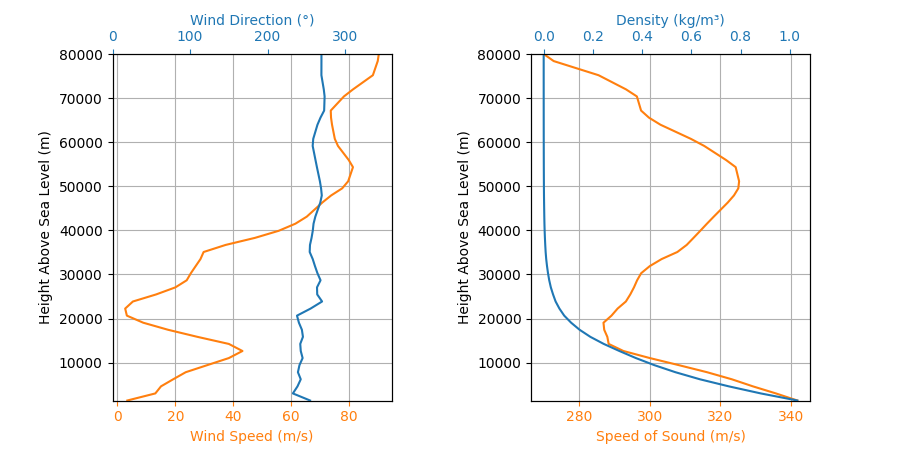

In [2]:
# Environment Configuration
env = Environment(latitude=31.04434, longitude=-103.53517, elevation=1400)

import datetime
tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)

env.set_atmospheric_model(type="Forecast", file="GFS")
env.info()

In [3]:
# Motor Definition

K2FullMotor = SolidMotor(
    thrust_source = r".\Raw Data\Valkyrie\K-2FullScaleTest.eng",
    dry_mass = 5.44311,
    dry_inertia = (0.475, 0.475, 0.007),
    nozzle_radius = 0.06858/2,
    grain_number = 6,
    grain_density = 1501.44939, #calculated from Matt's sim
    grain_outer_radius = 0.082296/2,
    grain_initial_inner_radius = 0.0381/2,
    grain_initial_height = 0.147955,
    grain_separation = 0,
    grains_center_of_mass_position=0.508,
    center_of_dry_mass_position=0.4826,
    nozzle_position=0,
    burn_time = 4.06,
    throat_radius = 0.02794/2,
    coordinate_system_orientation="nozzle_to_combustion_chamber"
)


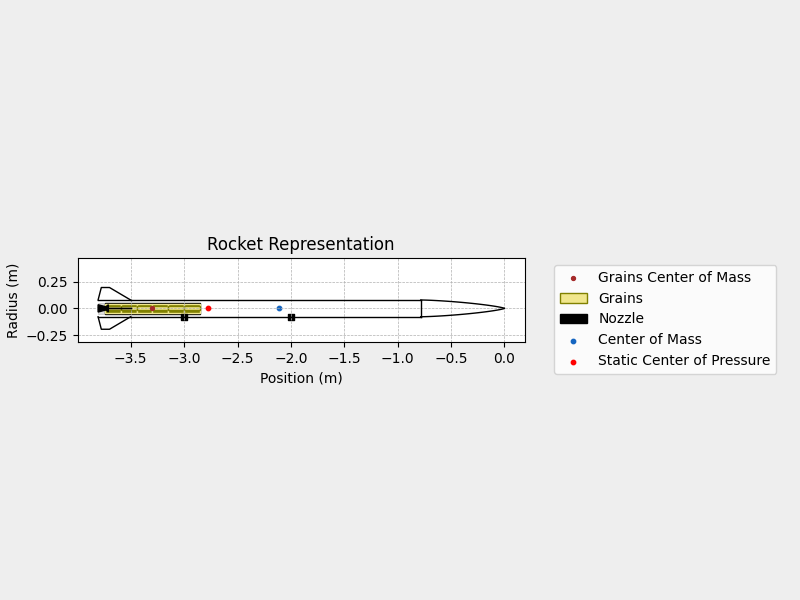

In [ ]:
# Define Rocket
Valkyrie = Rocket(
    radius = 0.157/2,
    mass = 24.76,
    inertia = (0.1, 16.81, 16.81),
    power_off_drag="Raw Data/Valkyrie/SolidWorks_Power Off Drag Curve.csv",
    power_on_drag="Raw Data/Valkyrie/SolidWorks_Power Off Drag Curve.csv",
    center_of_mass_without_motor=2.08,
    coordinate_system_orientation="nose_to_tail",
)
Valkyrie.add_motor(K2FullMotor, position =3.806)

rail_buttons = Valkyrie.set_rail_buttons(
    upper_button_position=3,
    lower_button_position = 2,
    angular_position=0,
)

fin_set = Valkyrie.add_trapezoidal_fins(
    n=4,
    root_chord=0.305,
    tip_chord = 0.0767,
    span = 0.117,
    position = 3.501,
    cant_angle = 0,
    sweep_angle = 59.44,
)

nose_cone = Valkyrie.add_nose(
    length = 0.784, kind="von karman", position = 0
)

Drogue = Valkyrie.add_parachute(
    "Drogue", cd_s=1.00584, trigger="apogee", sampling_rate=100, lag=0
)

Main = Valkyrie.add_parachute(
    "Main", cd_s=2.34696, trigger=304.8, sampling_rate=100, lag=0
)
Valkyrie.draw()

In [5]:
# Nominal Flight Simulation
test_flight = Flight(
    rocket = Valkyrie, environment=env, rail_length=5.1, inclination=84.2, heading = 135)
test_flight.info()


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 919.72 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.382 | e1: -0.019 | e2: 0.047 | e3: -0.923
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.80° | Precession ψ: -135.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 4.202 c


Surface Wind Conditions

Frontal Surface Wind Speed: -0.60 m/s
Lateral Surface Wind Speed: 1.93 m/s


Launch Rail

Launch Rail Length: 5.1 m
Launch Rail Inclination: 84.20°
Launch Rail Heading: 135.00°


Rail Departure State

Rail Departure Time: 0.342 s
Rail Departure Velocity: 20.768 m/s
Rail Departure Stability Margin: 4.297 c
Rail Departure Angle of Attack: 5.553°
Rail Departure Thrust-Weight Ratio: 7.777
Rail Departure Reynolds Number: 1.966e+05


Burn out State

Burn out time: 4.060 s
Altitude at burn out: 1529.340 m (ASL) | 609.625 m (AGL)
Rocket speed at burn out: 270.053 m/s
Freestream v

# Begin Stochastic Modeling of Rocket

In [6]:
# Stochastic Environment

stochastic_env = StochasticEnvironment(
    environment = env,
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                919.7155151367188
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 31.04434
	longitude                -103.53517
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)


In [7]:
#  Stochastic Motor
stochastic_motor = StochasticSolidMotor(
    solid_motor=K2FullMotor,
    burn_start_time = (0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    dry_mass = 0.96,
    grain_separation=1/1000,
    grain_initial_height = 1 /1000,
    throat_radius = 0.5/1000,
    nozzle_radius = 0.5/1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    4.06
	center_of_dry_mass_position      0.4826
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.475
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.475
	dry_I_23                         0
	dry_I_33                         0.007
	grain_density                    1501.44939
	grain_initial_inner_radius       0.01905
	grain_number                     6
	grain_outer_radius               0.041148
	interpolate                      linear
	thrust_source                    [[0, 0], [0.015, 1137.68], [0.045, 2557.084], [0.05, 2607.434], [0.065, 2669.773], [0.13, 2667.375], [0.16, 2662.58], [0.205, 2657.784], [0.4, 2710.533], [0.545, 2784.859], [0.795, 2916.73], [0.845, 2952.694], [1.005, 3062.986], [1.1, 3110.938], [1.16, 3146.903], [1.16, 3146.903], [1.305, 3230.82], [1.

In [8]:
# Stochastic Rocket

stochastic_rocket = StochasticRocket(
    rocket = Valkyrie,
    radius = 0.0127/1000,
    mass = 0.24,
    power_off_drag_factor= (1,0.1),
    power_on_drag_factor=(1,0.1),
)

stochastic_rocket.add_motor(stochastic_motor, position=0.001),
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_11_without_motor              0.1
	I_12_without_motor              0
	I_13_without_motor              0
	I_22_without_motor              16.82
	I_23_without_motor              0
	I_33_without_motor              16.82
	center_of_mass_without_motor    -1.58
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	mass                            24.76000 ± 0.24000 (normal)
	power_off_drag_factor           1.00000 ± 0.10000 (normal)
	power_on_drag_factor            1.00000 ± 0.10000 (normal)
	radius                          0.07850 ± 0.00001 (normal)


In [9]:
# Stochastic Flight
stochastic_flight = StochasticFlight(
    flight = test_flight,
    inclination = 2.5,
    heading = 10,
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5.1

Stochastic Attributes:
	heading               135.00000 ± 10.00000 (normal)
	inclination           84.20000 ± 2.50000 (normal)


In [10]:
# Monte Carlo Simulation
test_dispersion = MonteCarlo(
    filename = "MonteCarlo/ValkyrieMC",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

test_dispersion.simulate(
    number_of_simulations=500,
    append=False,
    include_function_data=False,
    parallel=True,
    n_workers = 10,
)

The following input file was imported: MonteCarlo\ValkyrieMC.inputs.txt
A total of 500 simulations results were loaded from the following output file: MonteCarlo\ValkyrieMC.outputs.txt

The following error file was imported: MonteCarlo\ValkyrieMC.errors.txt                                          
Starting Monte Carlo analysis                                          
Running Monte Carlo simulation with 10 workers.


c:\Users\Andrew\Documents\High Power Rocket Team\RocketPy\venv\Lib\site-packages\rocketpy\simulation\monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Results saved to MonteCarlo\ValkyrieMC.outputs.txt


In [11]:
test_dispersion.num_of_loaded_sims
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  MonteCarlo\ValkyrieMC
Number of simulations:  500
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
                 x_impact         794.648         780.424         353.453         105.646        1524.927
          impact_velocity        -319.436        -319.216          11.852        -345.935        -297.639
                 apogee_x         429.630         424.216         191.380          57.078         817.406
     frontal_surface_wind          -0.586          -0.600           0.314          -1.191           0.032
     lateral_surface_wind           1.906           1.930           0.101           1.634           2.021
              apogee_time          25.113          25.083           0.520          24.187          26.272
                 apogee_y        -426

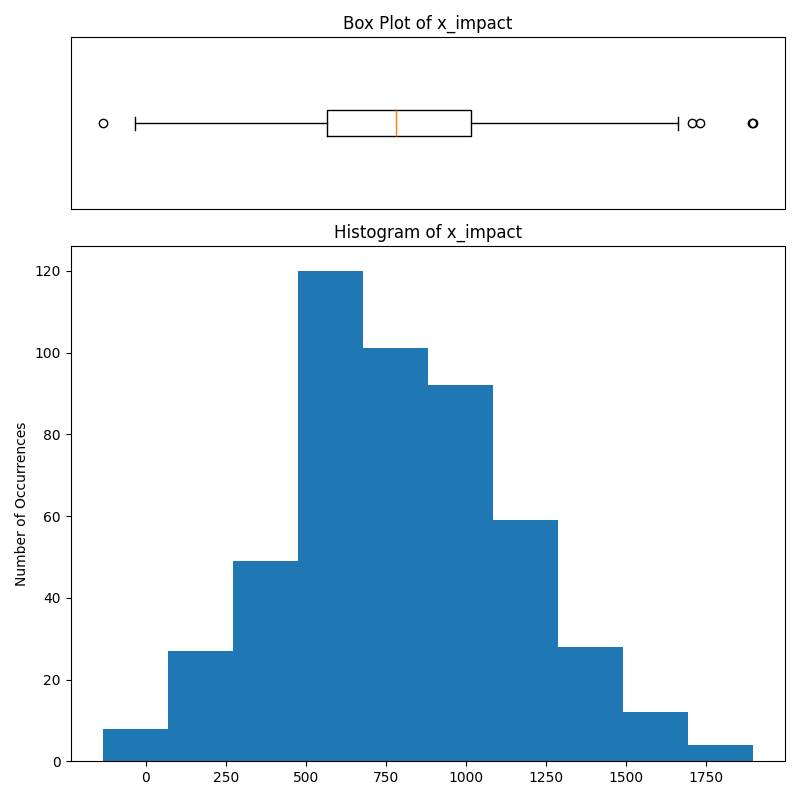

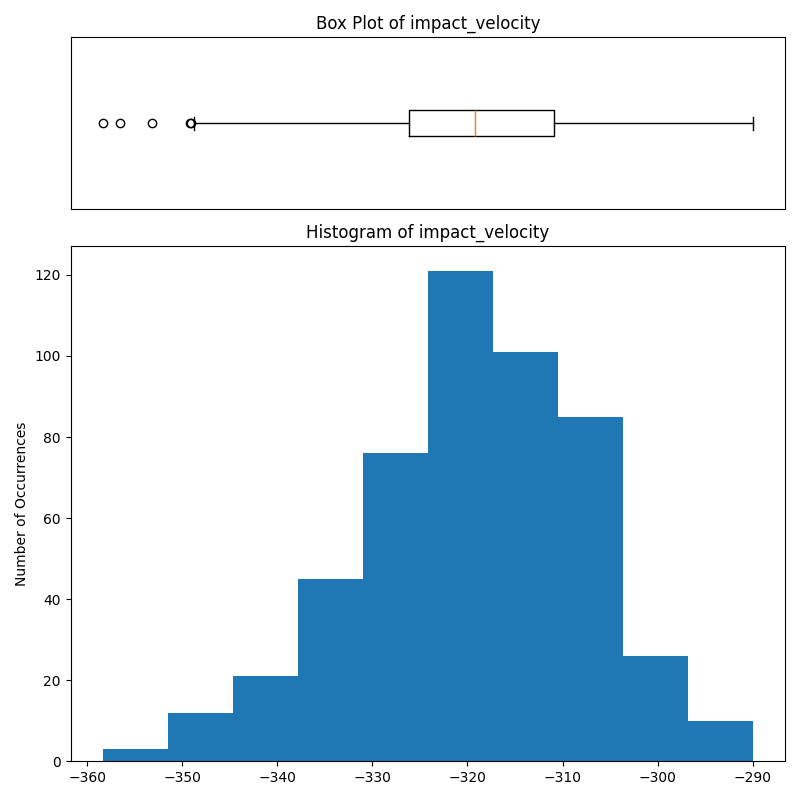

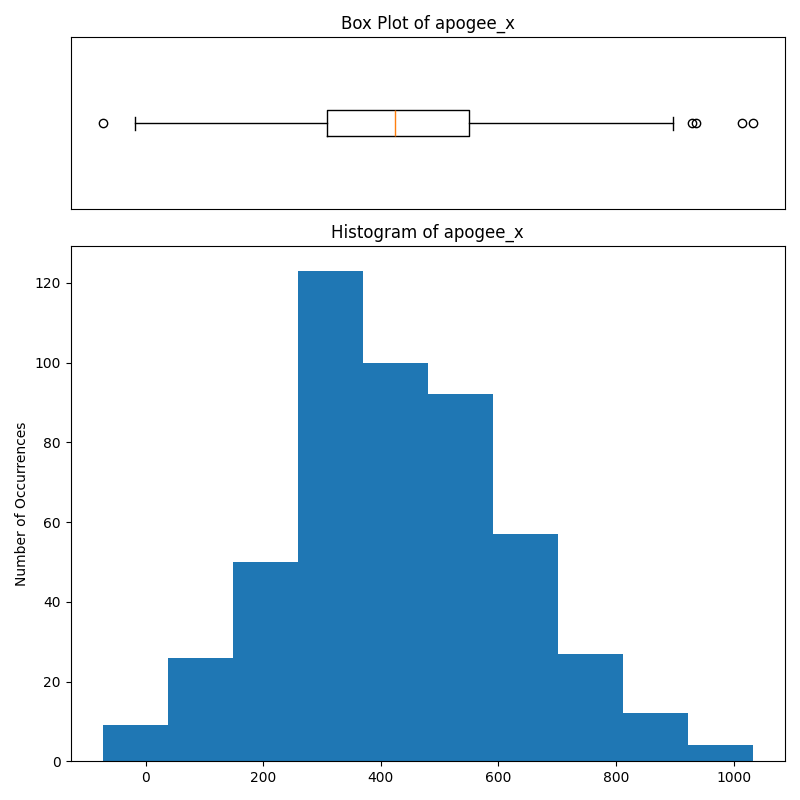

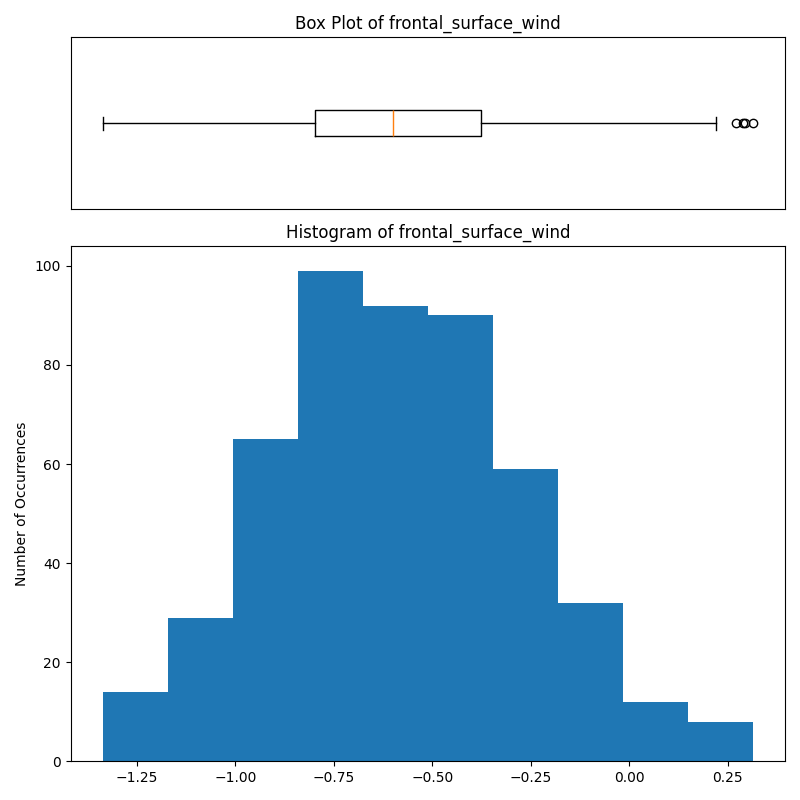

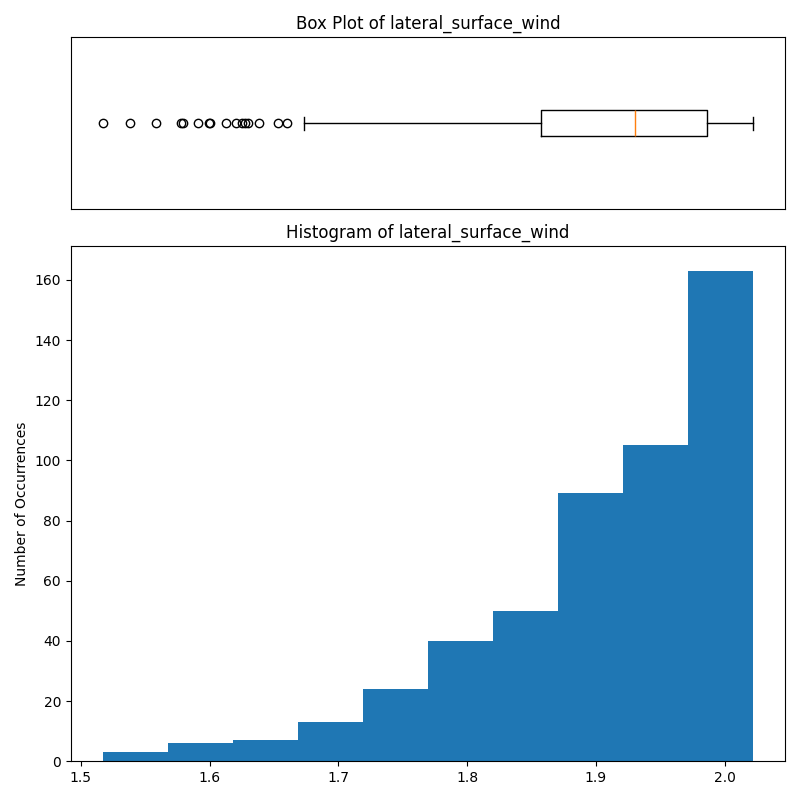

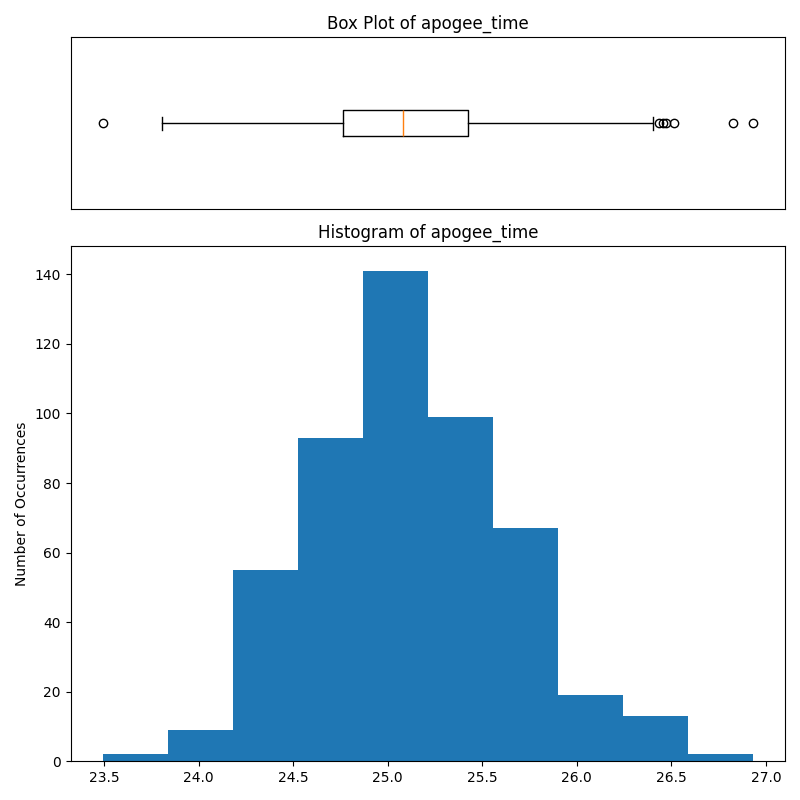

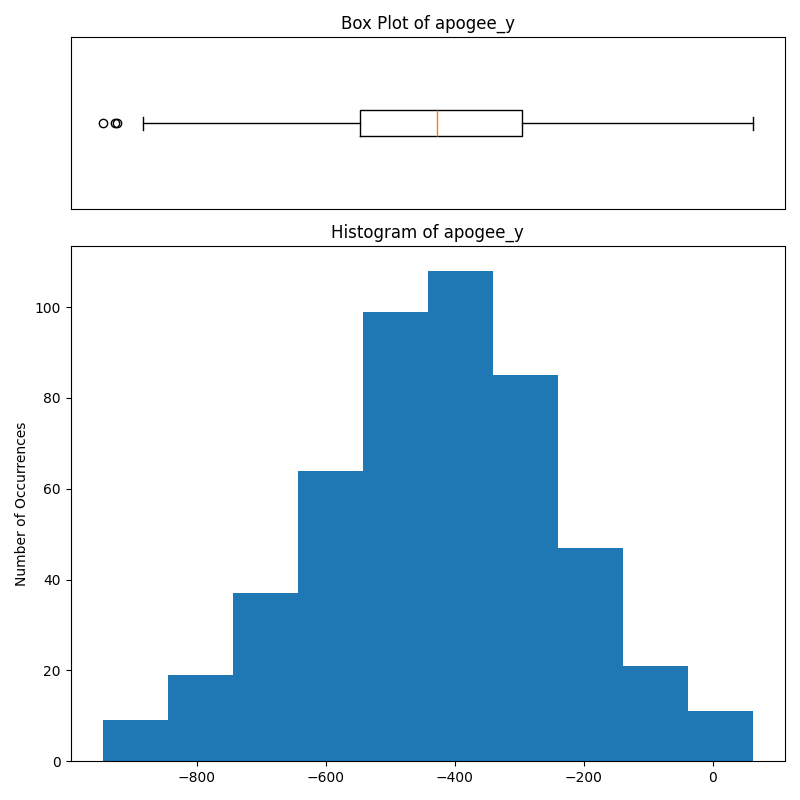

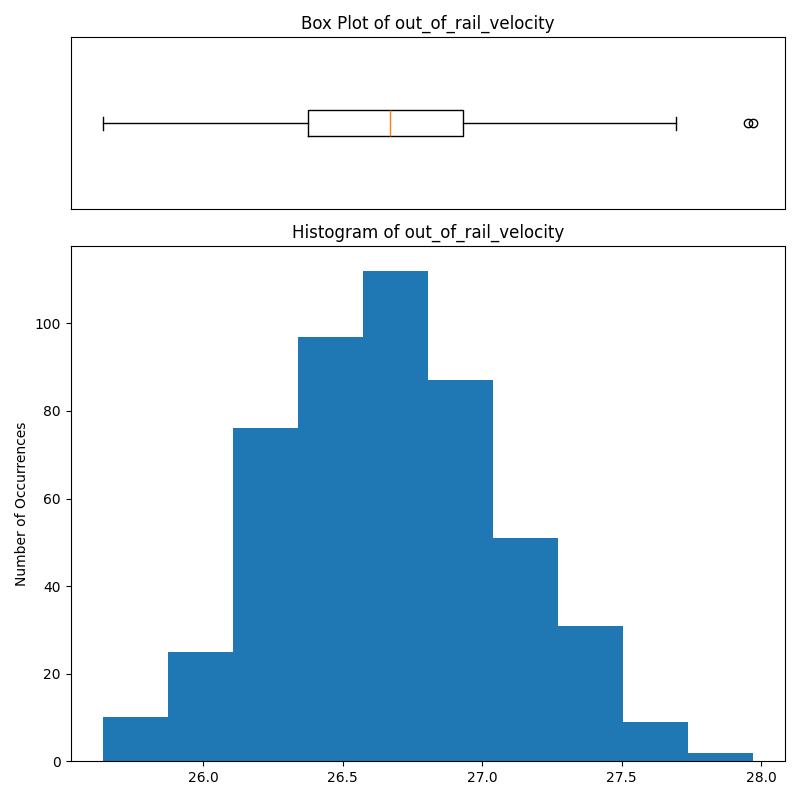

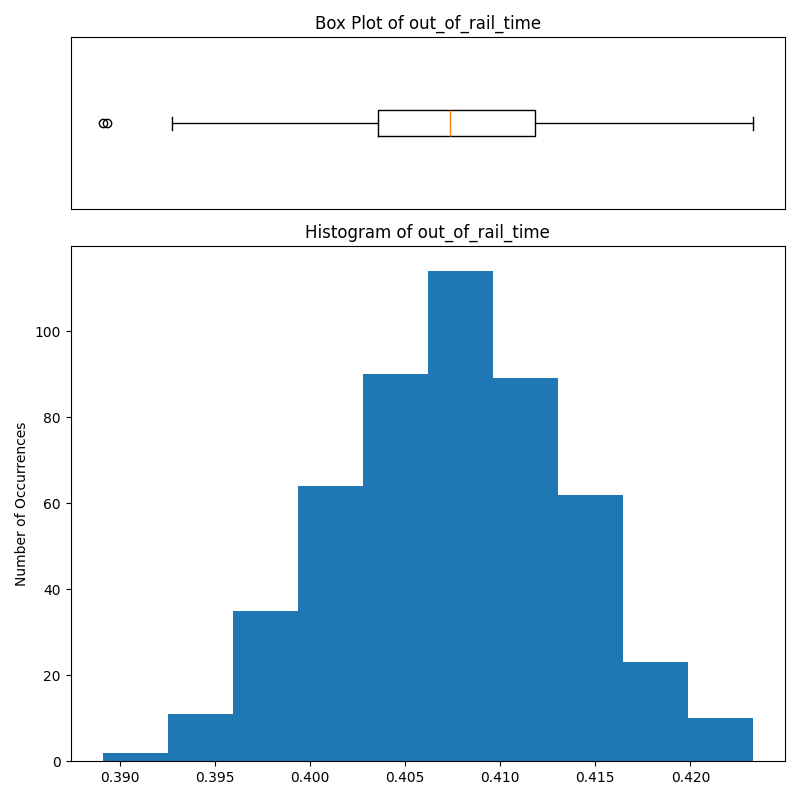

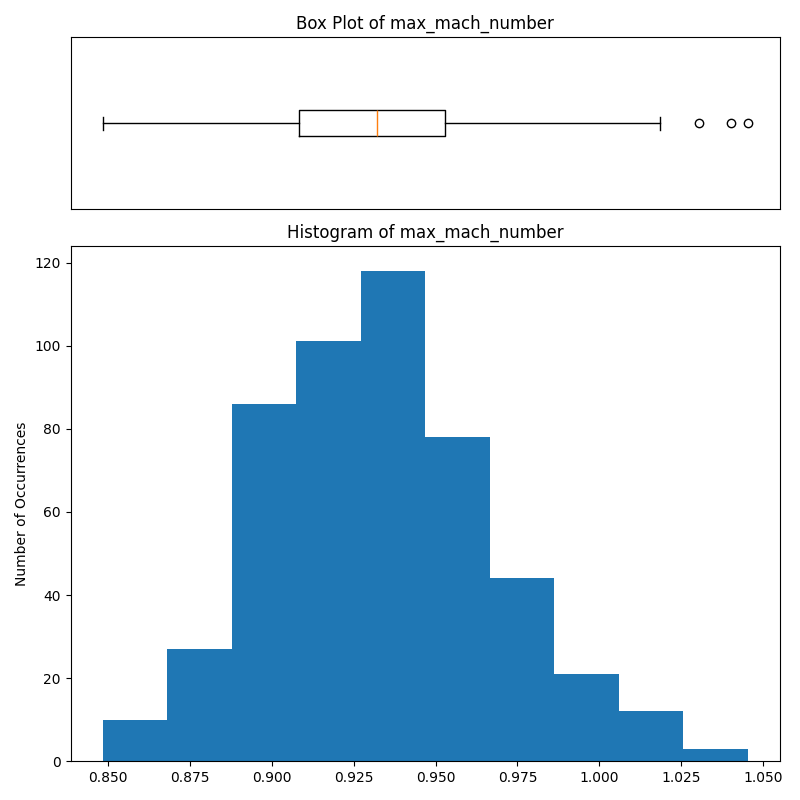

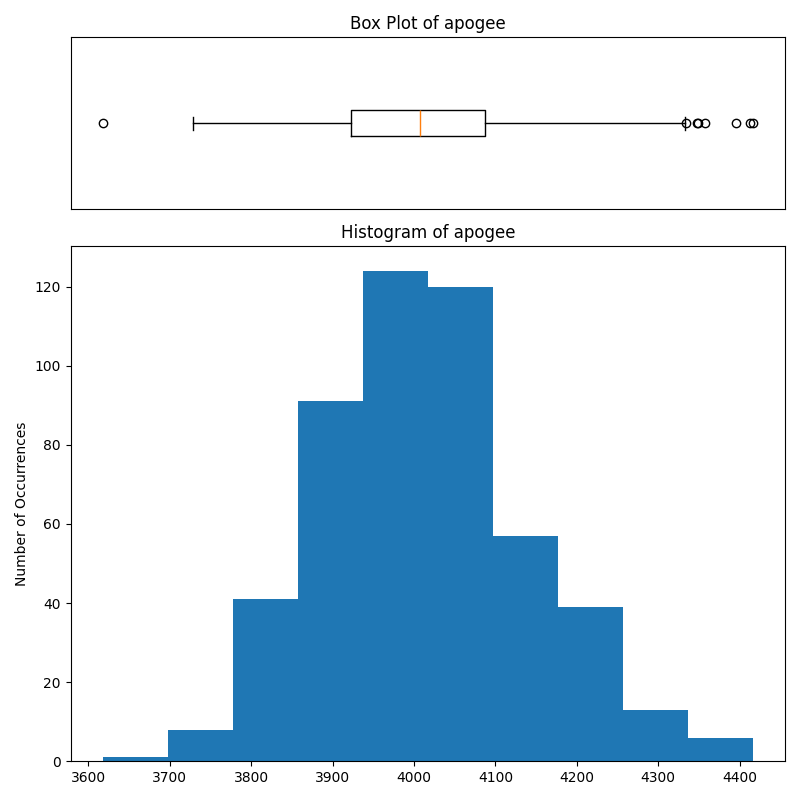

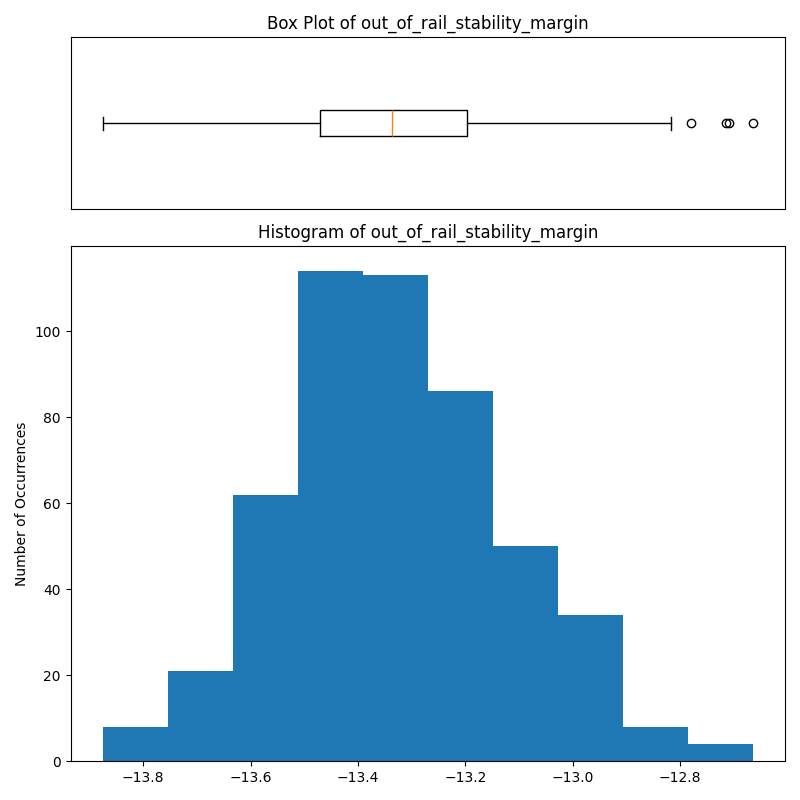

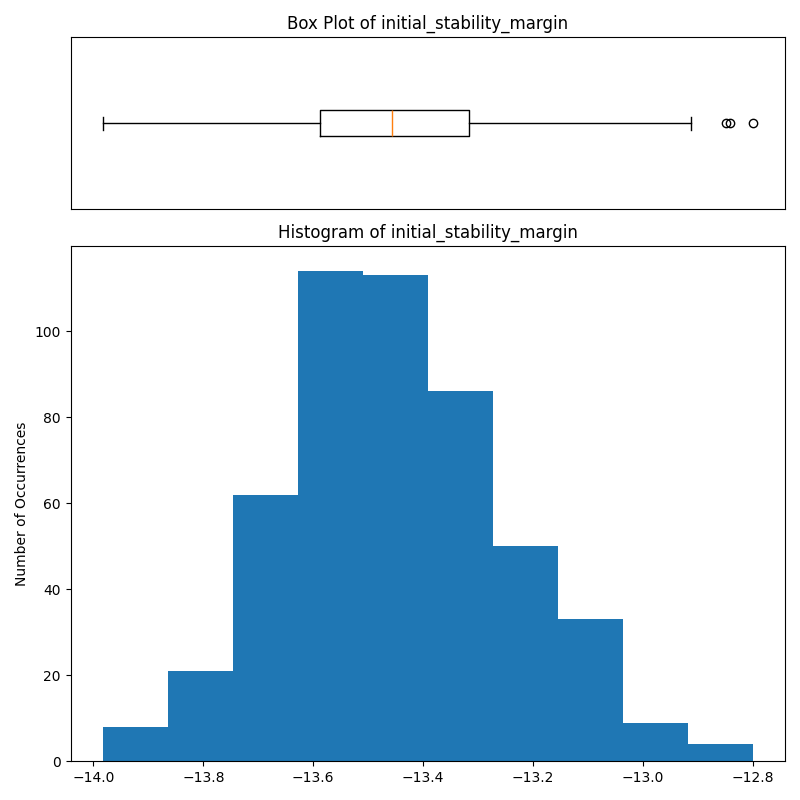

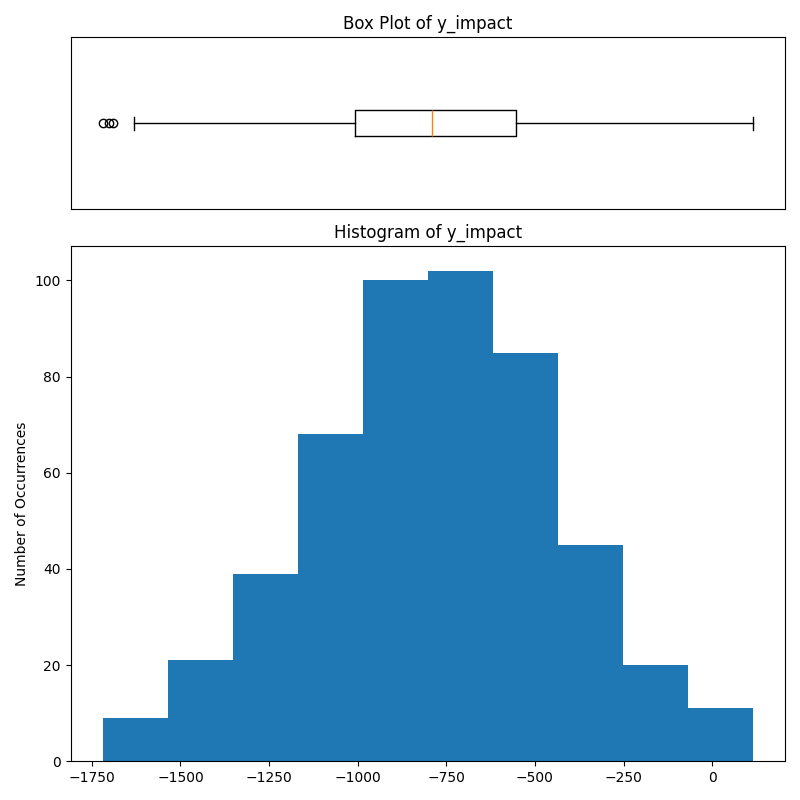

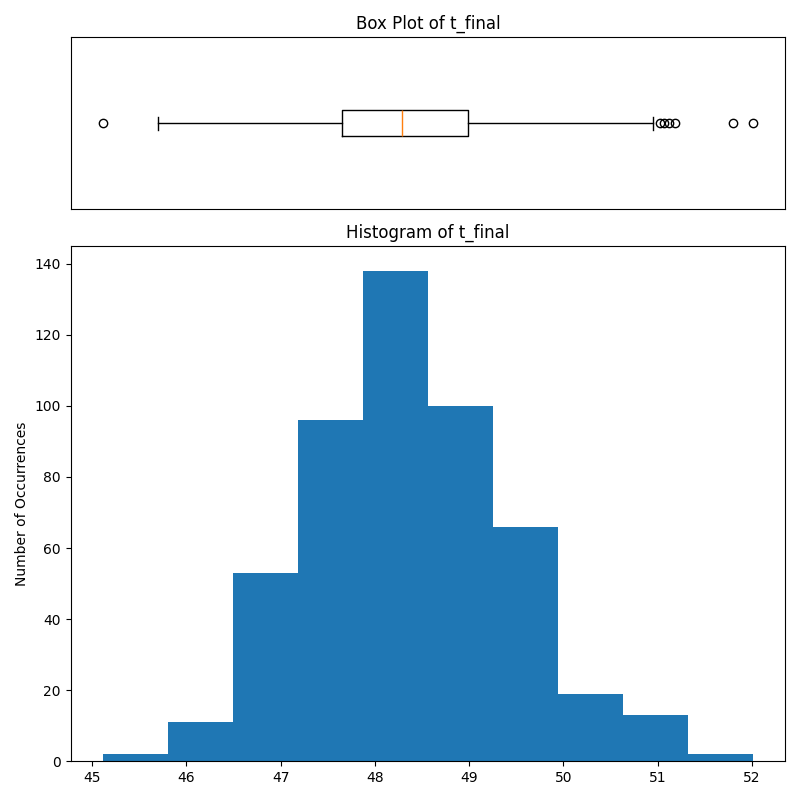

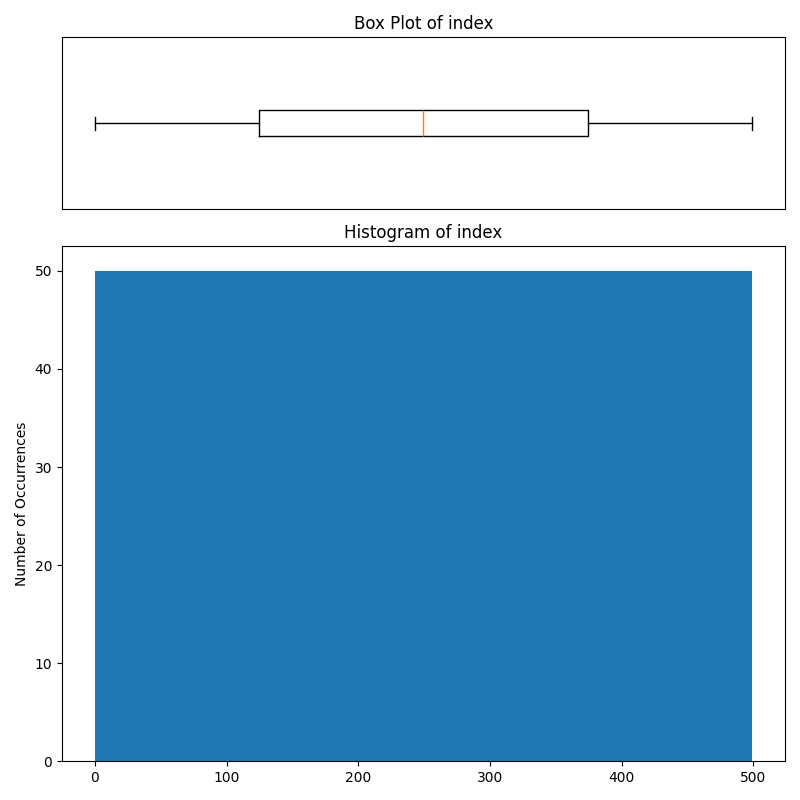

In [12]:
test_dispersion.plots.all()